In [3]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
import tcripser
import gudhi,gudhi.hera,gudhi.wasserstein,persim
import ase
from ase.io import cube
from ase.io import cif
import multiprocessing
from multiprocessing.dummy import Pool
import pickle
import json

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
inDir="Z:/data/diverse_metals/diverseTop"
topTypes=os.listdir(inDir)
topTypes

['tFunc', 'tThresh-05', 'tThresh0']

In [4]:
fName="DB7-ddmof_15992_PH" #


## Let's plot some PH
- find relatively good bounds to discretize

In [8]:
diags=np.load(f"{inDir}/{topTypes[0]}/{fName}.npy",allow_pickle=True)

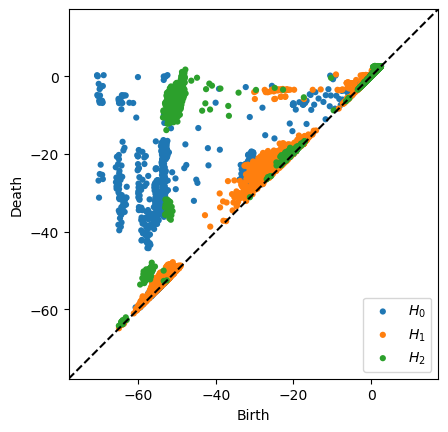

In [10]:
persim.plot_diagrams(list(diags))

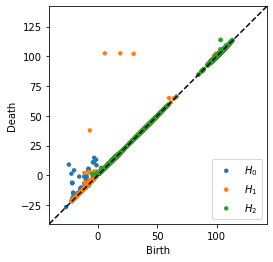

In [7]:
fName="DB7-ddmof_15992_PH"
diags2=np.load(f"{inDir}/{topTypes[1]}/{fName}.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

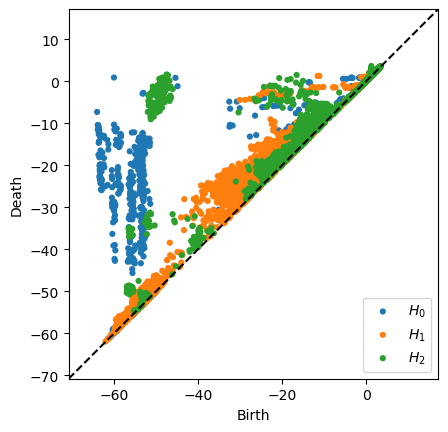

In [12]:
fName="DB1-Cu2O8-pcn6_B-TDPAT_No456_PH"
diags2=np.load(f"{inDir}/{topTypes[0]}/{fName}.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

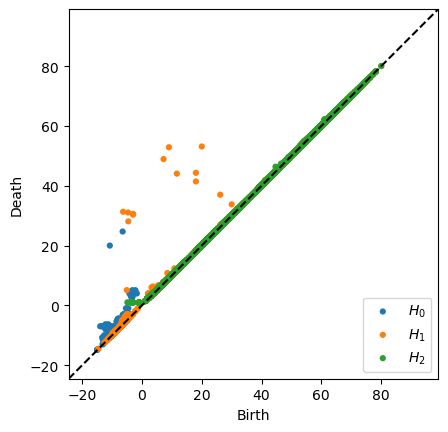

In [8]:
fName="DB1-Cu2O8-pcn6_B-TDPAT_No456_PH"
diags2=np.load(f"{inDir}/{topTypes[1]}/{fName}.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

# Let's grab some outliars in the data and see if they have any apparent patterns

In [5]:
df=pd.read_csv(r"Z:\data\diverse_metals\post-combustion-vsa-2-clean.csv",index_col=0)

In [14]:
df.head()

,filename,mmol/g_working_capacity,selectivity
0,DB0-m3_o12_o22_f0_pcu.sym.90,0.370563,13.582315
1,DB0-m3_o16_o460_f0_fsc.sym.19,2.774926,196.043735
2,DB0-m3_o8_o23_f0_pcu.sym.155,0.531669,8.000730
3,DB5-hypotheticalMOF_5044966_0_0_1_3_24_6,1.703426,67.395940
4,DB0-m3_o155_o151_f0_fsc.sym.13,0.937707,26.451195


Text(0.5, 0, 'mmol/g_working_capacity')

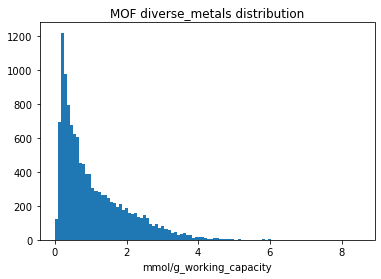

In [10]:
plt.hist(df["mmol/g_working_capacity"],bins=100) #>3.5 - 4
plt.title("MOF diverse_metals distribution")
plt.xlabel("mmol/g_working_capacity")

(array([3.644e+03, 1.545e+03, 8.530e+02, 6.570e+02, 6.230e+02, 5.590e+02,
        3.990e+02, 4.170e+02, 3.450e+02, 3.210e+02, 2.720e+02, 2.900e+02,
        2.680e+02, 2.420e+02, 2.150e+02, 2.080e+02, 1.610e+02, 1.630e+02,
        1.560e+02, 1.290e+02, 1.050e+02, 9.100e+01, 7.300e+01, 6.400e+01,
        5.300e+01, 5.700e+01, 4.400e+01, 2.500e+01, 3.100e+01, 2.400e+01,
        3.500e+01, 1.600e+01, 1.300e+01, 1.600e+01, 1.100e+01, 9.000e+00,
        5.000e+00, 1.000e+01, 1.100e+01, 4.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 4.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

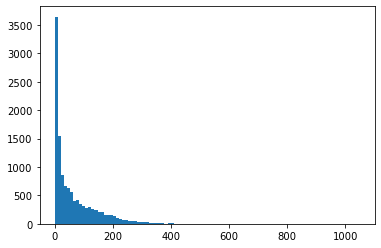

In [6]:
plt.hist(df["selectivity"],bins=100) #>300

In [62]:
bounds={"selectivity":300,"mmol/g_working_capacity":3.75}

In [8]:
PHvec=np.zeros(tBins+4,dtype=np.int32)
"""PHvec is frequency projection to:
First 4 elements cover outside bounds [#belowPersistent,#abovePersistent,belowWeak,aboveWeak, ...]
the rest of PHvec, PHvec[4:] is a vertical, then right sweep of the bounding triangle

each [b,d] pair maps to a projection of the number of points within that region
PHvec[4:]=[in(-25,-25),in(-25,-24),..,in(-25,50),...,in(50,50)]
"""



'PHvec is frequency projection to:\nFirst 4 elements cover outside bounds [#belowPersistent,#abovePersistent,belowWeak,aboveWeak, ...]\nthe rest of PHvec, PHvec[4:] is a vertical, then right sweep of the bounding triangle\n\neach [b,d] pair maps to a projection of the number of points within that region\nPHvec[4:]=[in(-25,-25),in(-25,-24),..,in(-25,50),...,in(50,50)]\n'

In [63]:
bounds={"selectivity":300,"mmol/g_working_capacity":3.75}

selectAll=pd.DataFrame((i for _,i in df.iterrows() if False not in {i[k]>bounds[k] for k in bounds.keys()}))

In [31]:
len(selectAll)

21

In [36]:
selectAll

,filename,mmol/g_working_capacity,selectivity
1033,DB12-NEYZAU_clean,4.727319,564.061035
1109,DB12-IQEKOG_clean,5.701334,327.561420
2027,DB12-CUZBUW_clean,3.842521,300.440480
2158,DB12-LOBHAM_clean,5.786555,309.539870
2808,DB12-SERWAP_freeONLY,4.967852,309.405780
2858,DB5-hypotheticalMOF_5081767_0_0_2_29_1_14,5.144488,311.509245
3315,DB5-hypotheticalMOF_22163_0_0_1_11_10_13,4.884263,324.403595
3461,DB12-NAWKII_clean,3.905228,304.836540
4983,DB5-hypotheticalMOF_5050675_0_0_1_23_3_12,3.792218,351.761515
5018,DB1-Zn2O8-fum_A-irmof20_A_No142,7.928258,336.277145


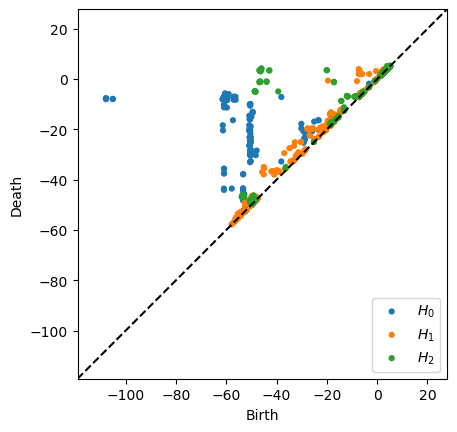

In [38]:
fName="DB12-TOXNIF_clean"
diags2=np.load(f"{inDir}/{topTypes[0]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

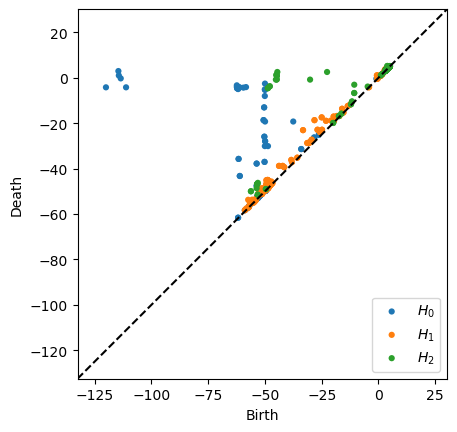

In [39]:
fName="DB12-CUZBUW_clean"
diags1=np.load(f"{inDir}/{topTypes[0]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))

In [ ]:
#side by side

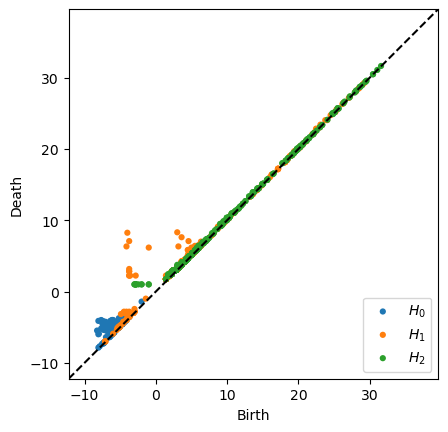

In [110]:
fName="DB12-TOXNIF_clean"
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

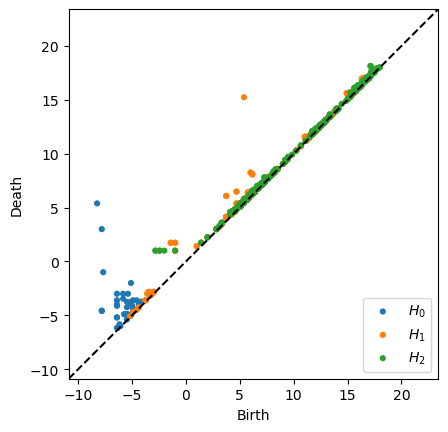

In [159]:
fName="DB12-CUZBUW_clean"
diags1=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))

In [15]:
maxesb0={k:np.array([np.max(np.load(f"{inDir}/{k}/{fName}_PH.npy",allow_pickle=True)[0]) for fName in df["filename"]]) for k in topTypes}

KeyboardInterrupt: 

In [ ]:
maxesb2={k:np.array([np.max(np.load(f"{inDir}/{k}/{fName}_PH.npy",allow_pickle=True)[2]) for fName in df["filename"]]) for k in topTypes}

In [18]:
bounds0={k:[np.zeros(len(df["filename"])),np.zeros(len(df["filename"]))] for k in topTypes}
bounds1={k:[np.zeros(len(df["filename"])),np.zeros(len(df["filename"]))] for k in topTypes}
bounds2={k:[np.zeros(len(df["filename"])),np.zeros(len(df["filename"]))] for k in topTypes}

for k in topTypes:
    i=0
    for fName in df["filename"]:
        dat=np.load(f"{inDir}/{k}/{fName}_PH.npy",allow_pickle=True)
        bounds0[k][0][i]=np.min(dat[0])
        bounds0[k][1][i]=np.max(dat[0])
        bounds1[k][0][i]=np.min(dat[1])
        bounds1[k][1][i]=np.max(dat[1])
        bounds2[k][0][i]=np.min(dat[2])
        bounds2[k][1][i]=np.max(dat[2])
        i+=1

In [33]:
bounds1={k:[np.zeros(len(df["filename"])),np.zeros(len(df["filename"]))] for k in topTypes}


for k in topTypes:
    i=0
    for fName in df["filename"]:
        dat=np.load(f"{inDir}/{k}/{fName}_PH.npy",allow_pickle=True)
        bounds1[k][0][i]=np.min(dat[1])
        bounds1[k][1][i]=np.max(dat[1])

        #bounds2[k][0][i]=np.min(dat[2])
        #bounds2[k][1][i]=np.max(dat[2])
        i+=1

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-152.04285413, -151.87287033, -151.70288654, ...,   17.6009736 ,
          17.77095739,   17.94094119]),
 <a list of 2 BarContainer objects>)

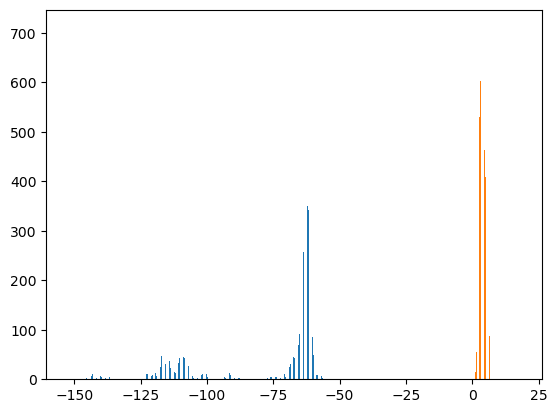

In [19]:
plt.hist(bounds0['tFunc'],bins=1000)

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-74.67679458, -74.57790385, -74.47901311, ...,  24.01616071,
         24.11505145,  24.21394218]),
 <a list of 2 BarContainer objects>)

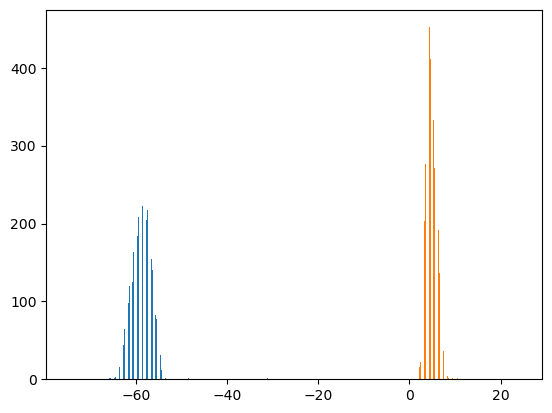

In [53]:
plt.hist(bounds1['tFunc'],bins=1000)

(array([[1., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-37.2424489 , -37.07719864, -36.91194838, ..., 127.67731174,
        127.842562  , 128.00781226]),
 <a list of 2 BarContainer objects>)

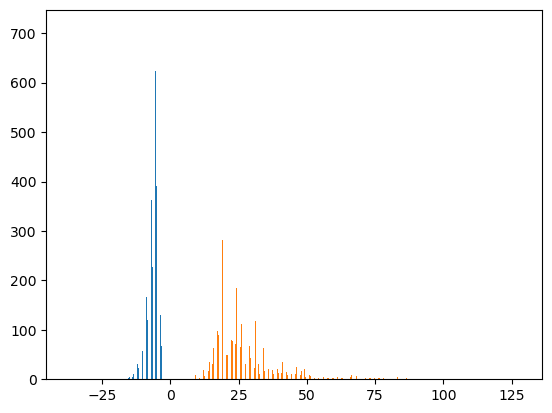

In [56]:
plt.hist(bounds1[topTypes[2]],bins=1000)

In [57]:
topTypes

['tFunc', 'tThresh-05', 'tThresh0']

In [27]:
max(bounds0[topTypes[2]][1])

103.0

In [31]:
sum([1 for i in bounds0[topTypes[2]][1] if i>20])

198

ValueError: x must have 2 or fewer dimensions

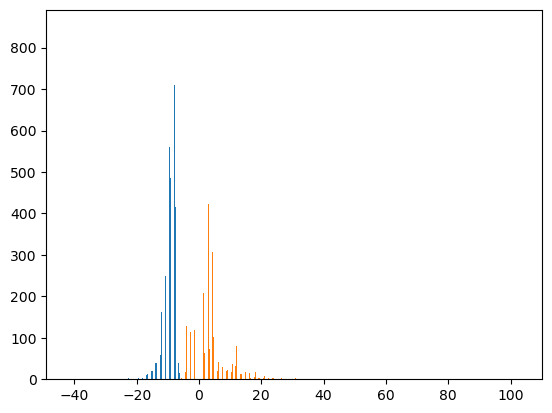

In [21]:
plt.hist(plt.hist(bounds0[topTypes[2]],bins=1000))

ValueError: x must have 2 or fewer dimensions

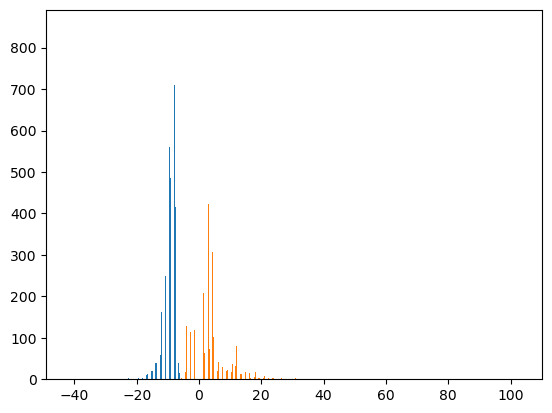

In [32]:
plt.hist(plt.hist(bounds0[topTypes[1]],bins=1000))

ValueError: x must have 2 or fewer dimensions

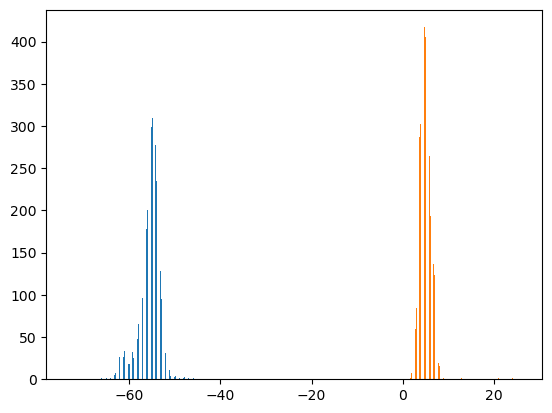

In [24]:
plt.clf()
plt.hist(plt.hist(bounds2[topTypes[0]],bins=1000))

ValueError: x must have 2 or fewer dimensions

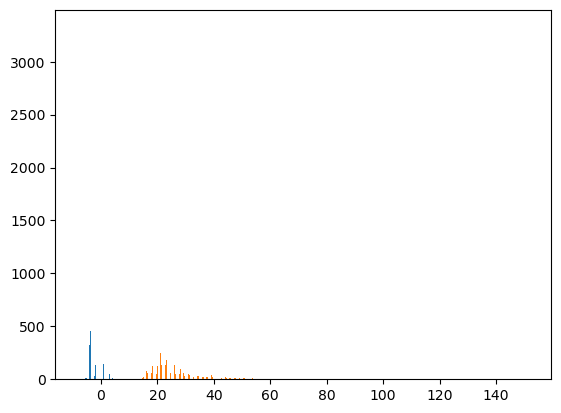

In [23]:
plt.clf()
plt.hist(plt.hist(bounds2[topTypes[2]],bins=1000))

ValueError: x must have 2 or fewer dimensions

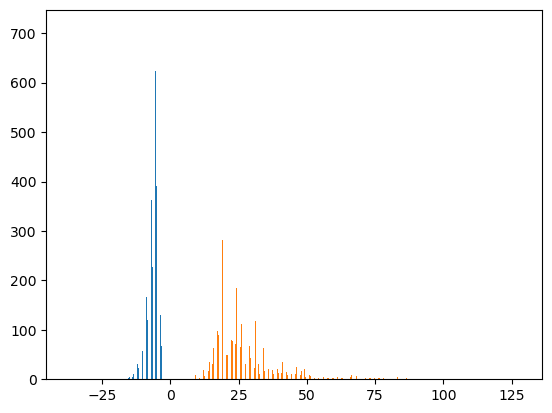

In [119]:
plt.clf()
plt.hist(plt.hist(bounds1[topTypes[2]],bins=1000))

In [48]:
np.random.seed(42)
randMof=np.random.choice(len(df["filename"]),size=150,replace="False")

In [49]:
randMof

array([ 7270,   860,  5390,  5191, 11964, 11284,  5734,  6265,   466,
        4426,  5578, 11636, 11363, 11111,  8322,  1685,   769, 10583,
        6949,  2433,  5311,  5051,  6420,  1184,  4555,  3385,  6396,
       11096,  8666,  9274,  2558,  7849,  2047,  2747,  9167,  9998,
         189,  2734,  3005,  4658,  1899,  7734,  1267,  1528, 11394,
        3556,  3890,  8838, 11080,  5393, 10627,  8792, 10555, 10253,
        8433, 10233, 11016,  7513,  2612,  7041,  9555,  6235,  5486,
        7099,  9670, 10748,   775,  8226,  3152, 10147,  1585,  3943,
        7555,  3073,  1021, 11653, 10805,  3843,  7989,  9692,  6873,
        5675,   161,  4297, 10173,   995, 11534,  7629, 11990,  9467,
        1016,  7869,  6439,  7892,  6863,  7916,  8529,   878,  9268,
        4887, 12185,  4859,  6331,  8571,  8684,  7208,  5276,  2062,
       12076,    64,  8006,  2568,  5463,  2027,  2695,  9687,  5258,
        5618,  6736,   391,  5892,  3561, 10470,  6184,  3099,  6278,
        8392,  3104,

In [50]:
subMof=df.iloc(0)[randMof]

In [58]:
subMof

,filename,mmol/g_working_capacity,selectivity
7270,DB0-m3_o153_o22_f0_fsc.sym.61,2.397933,166.126460
860,DB12-VULKIX_clean,1.462808,144.082065
5390,DB5-hypotheticalMOF_5055689_1_0_1_28_15_5,0.180313,1.422015
5191,DB0-m3_o14_o22_f0_pcu.sym.99,1.779169,97.214630
11964,DB12-WUXLEI_clean,1.323712,35.411010
...,...,...,...
6938,DB0-m3_o160_o1510_f0_fsc.sym.43,0.725963,24.163015
4488,DB0-m2_o16_o26_f0_pcu.sym.24,0.709071,17.543560
206,DB12-XIHXET_clean,1.321507,213.972265
5134,DB0-m3_o96_o11_f0_fsc.sym.9,1.414569,39.404695


(array([76., 33., 12., 14.,  5.,  3.,  3.,  2.,  1.,  1.]),
 array([  0.545795,  38.940459,  77.335123, 115.729787, 154.124451,
        192.519115, 230.913779, 269.308443, 307.703107, 346.097771,
        384.492435]),
 <BarContainer object of 10 artists>)

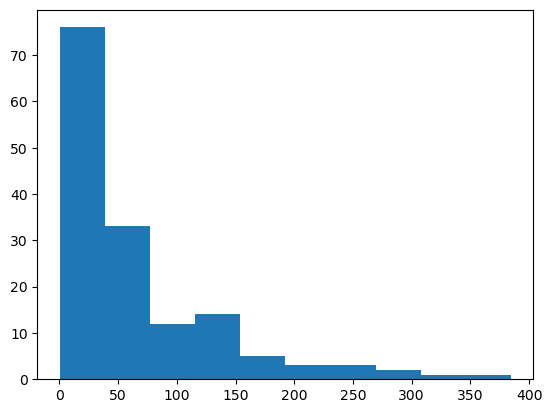

In [51]:
plt.hist(subMof["selectivity"])

(array([55., 27., 27., 15., 13.,  5.,  4.,  2.,  1.,  1.]),
 array([0.020213 , 0.5414606, 1.0627082, 1.5839558, 2.1052034, 2.626451 ,
        3.1476986, 3.6689462, 4.1901938, 4.7114414, 5.232689 ]),
 <BarContainer object of 10 artists>)

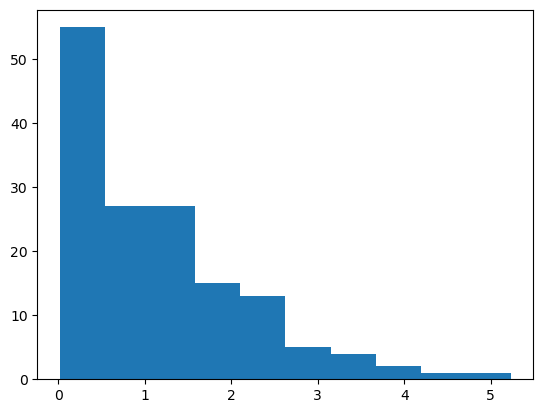

In [52]:
plt.hist(subMof["mmol/g_working_capacity"])

In [89]:
def wDist(mof1,mof2,b): ###SLOW! change to csv format
    return persim.wasserstein(np.load(f"{inDir}/{topTypes[2]}/{mof1}_PH.npy",allow_pickle=True)[b].astype("float64"),np.load(f"{inDir}/{topTypes[2]}/{mof2}_PH.npy",allow_pickle=True)[b].astype("float64"))

def bDist(mof1,mof2,b): ###SLOW! change to csv format
    return persim.bottleneck(np.load(f"{inDir}/{topTypes[2]}/{mof1}_PH.npy",allow_pickle=True)[b].astype("float64"),np.load(f"{inDir}/{topTypes[2]}/{mof2}_PH.npy",allow_pickle=True)[b].astype("float64"))

In [161]:
selectAll

,filename,mmol/g_working_capacity,selectivity
1033,DB12-NEYZAU_clean,4.727319,564.061035
1109,DB12-IQEKOG_clean,5.701334,327.561420
2027,DB12-CUZBUW_clean,3.842521,300.440480
2158,DB12-LOBHAM_clean,5.786555,309.539870
2808,DB12-SERWAP_freeONLY,4.967852,309.405780
2858,DB5-hypotheticalMOF_5081767_0_0_2_29_1_14,5.144488,311.509245
3315,DB5-hypotheticalMOF_22163_0_0_1_11_10_13,4.884263,324.403595
3461,DB12-NAWKII_clean,3.905228,304.836540
4983,DB5-hypotheticalMOF_5050675_0_0_1_23_3_12,3.792218,351.761515
5018,DB1-Zn2O8-fum_A-irmof20_A_No142,7.928258,336.277145


In [90]:

wDist(selectAll['filename'].iloc(0)[0],selectAll['filename'].iloc(0)[1],b=2)

251.8761475692359

In [95]:
bDist(selectAll['filename'].iloc(0)[0],selectAll['filename'].iloc(0)[1],b=0)

4.16227766016838

In [66]:
selectAll['filename'].iloc(0)[0]

'DB12-NEYZAU_clean'

In [97]:
subMof['filename'].iloc(0)[0]

'DB0-m3_o153_o22_f0_fsc.sym.61'

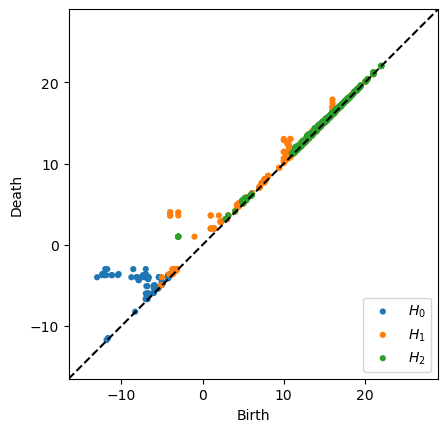

In [162]:

fName='DB1-Zn2O8-fum_A-irmof20_A_No142'
diags1=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))

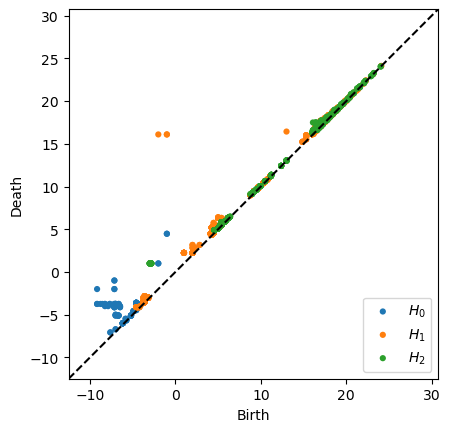

In [103]:
fName='DB12-NEYZAU_clean'
diags1=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))



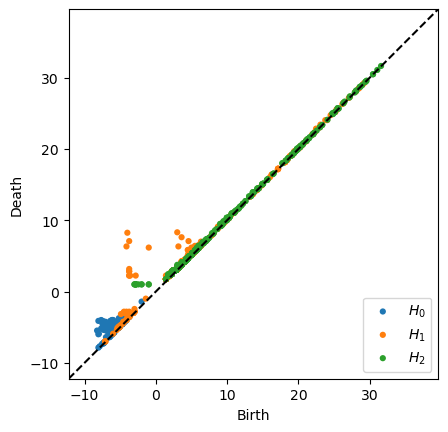

In [163]:
fName='DB12-TOXNIF_clean'
diags1=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))


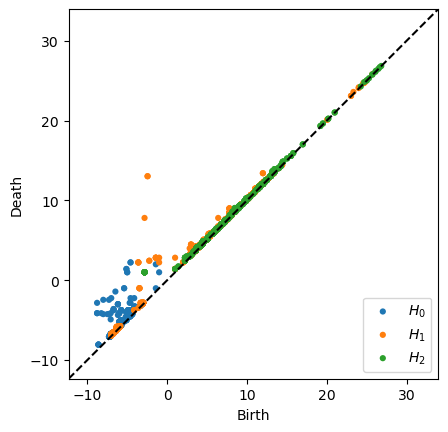

In [105]:
fName='DB12-LOBHAM_clean'
diags1=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags1))


### Below are not as good examples (random)

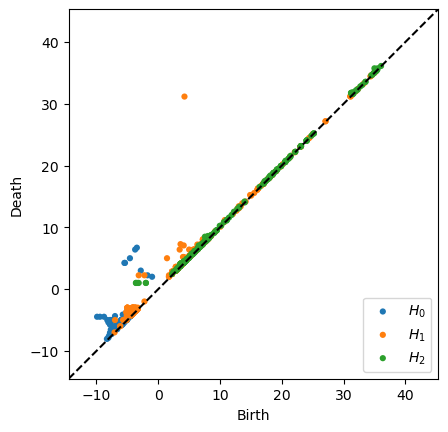

In [164]:
fName='DB5-hypotheticalMOF_5070462_0_0_2_3_16_4'
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

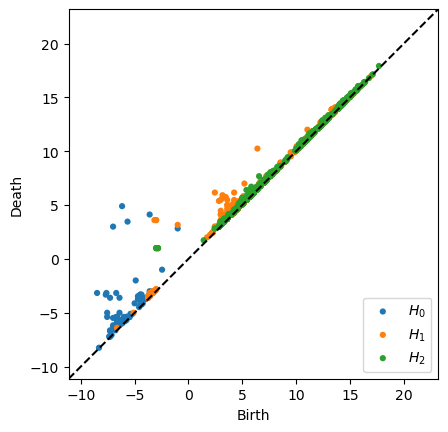

In [165]:

fName='DB0-m3_o22_o23_f0_pcu.sym.30' #1.4,72
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

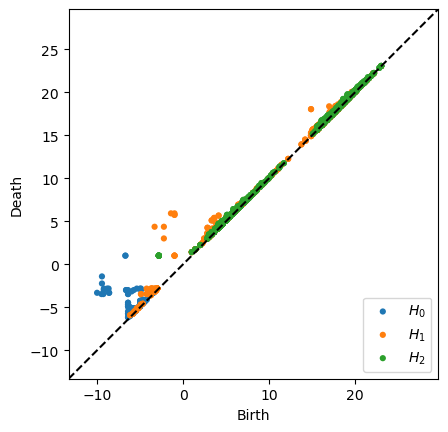

In [108]:
fName='DB12-KAYCIY_clean' #cap around 4, select around 200
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

In [91]:
wDist(selectAll['filename'].iloc(0)[0],subMof['filename'].iloc(0)[0],b=2)


130.07583346871274

In [96]:
bDist(selectAll['filename'].iloc(0)[0],subMof['filename'].iloc(0)[0],b=0)

2.4641016151377544

In [77]:
subMof.head()

,filename,mmol/g_working_capacity,selectivity
7270,DB0-m3_o153_o22_f0_fsc.sym.61,2.397933,166.126460
860,DB12-VULKIX_clean,1.462808,144.082065
5390,DB5-hypotheticalMOF_5055689_1_0_1_28_15_5,0.180313,1.422015
5191,DB0-m3_o14_o22_f0_pcu.sym.99,1.779169,97.214630
11964,DB12-WUXLEI_clean,1.323712,35.411010


In [111]:
bounds={"selectivity":375}

highSel=pd.DataFrame((i for _,i in df.iterrows() if False not in {i[k]>bounds[k] for k in bounds.keys()}))

In [115]:
len(highSel)

70

In [116]:
highSel.head()

,filename,mmol/g_working_capacity,selectivity
310,DB12-XUKLAS_clean,1.611874,503.93475
356,DB12-OQOXAV_clean,1.393388,482.22868
499,DB12-WEMDID_freeONLY,1.645496,495.63376
576,DB12-PEDMOB_freeONLY,1.375536,440.50403
777,DB12-VEHNED_clean,0.576213,495.55399


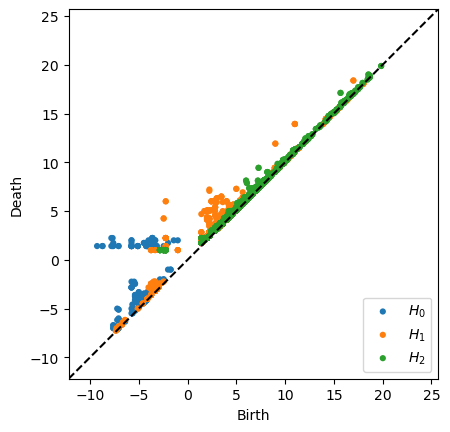

In [117]:
fName='DB12-VEHNED_clean'
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

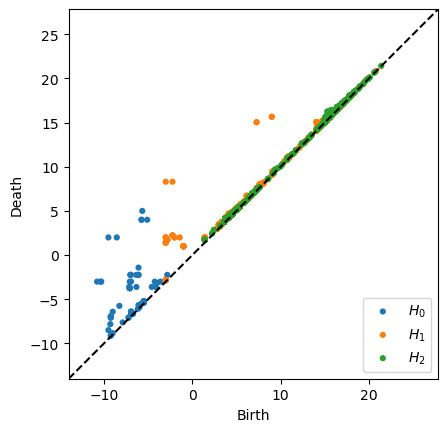

In [118]:
fName='DB12-WEMDID_freeONLY'
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

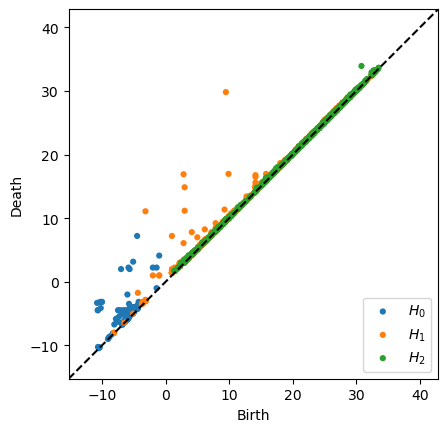

In [160]:

fName='DB5-hypotheticalMOF_5073350_0_0_2_19_8_8'
diags2=np.load(f"{inDir}/{topTypes[2]}/{fName}_PH.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

In [112]:
bounds={"mmol/g_working_capacity":3.75}

highCap=pd.DataFrame((i for _,i in df.iterrows() if False not in {i[k]>bounds[k] for k in bounds.keys()}))

In [114]:
highCap.head()

,filename,mmol/g_working_capacity,selectivity
87,DB5-hypotheticalMOF_24443_0_0_1_5_9_7,5.785946,225.072265
94,DB0-m3_o17_o114_f0_fsc.sym.53,3.879300,193.270855
187,DB1-Cu2O8N2-AZO_A-DABCO_A_No15,4.466832,107.618930
231,DB15-pcu_N139_E120_opt,5.205740,216.439560
626,DB12-WAMRIN01_clean,5.368655,198.398765


## NAIVE model 1:

Regression, B1: (tThresh0)
- Number and lifetime (intensity) of points that are born below 0
- - high intensity points should increase selectivity
- working cap is affected by number/lifetime of points below 0 (minus -) number/intensity above 0.

In [6]:
b1thresh=[-25,50]
outLifetimeThresh=1
tBins=int(((b1thresh[1]-b1thresh[0])**2+b1thresh[1]-b1thresh[0])/2)
## vectorize:



In [7]:
tBins

2850

In [7]:
def indexMap(b,d,mi,ma,thresh=1):
    ## Let's distinguish from points above and below 0 in the future - for now we are guaranteed that -25 is the true lowest bound

    life = ma - mi +1 # technically b1thresh but let's keep it this way for now & assert type(mi,ma) ==(int,int)
    rows = round((b - mi))
    persist=d - b
    if rows < 0:
        if persist > thresh:
            return 0  # belowPersistent
        else:
            return 2  # belowWeak
    elif rows > life:
        if persist > thresh:
            return 1  # abovePersistent
        else:
            return 3  # aboveWeak
    else:
        if d>ma:
            if persist > thresh:
                return 1 # abovePersistent ---- maybe we should separate into those abovePersistent
                    #with (b<0,b>=0) respectively? --looking at error cases it seems we're lucky and don't have
                    ### to deal with it for now (good bounds)

                    ####Remember, we can always decode the frequency plot (for resolution within bounds)
            else:
                return 3 # aboveWeak
        rowskip = life - rows
        return round(4 + (life * (life + 1) - rowskip * (rowskip + 1)) / 2 + d - b)


In [11]:
mi,ma=b1thresh[0],b1thresh[1]

indexMap(50,49,mi,ma,thresh=1)

2853

In [16]:
indexMap(-25,-25,mi,ma,thresh=1)

4.0

## Time to vectorize -- grab all B1 and we'll throw the intensities into an integer vector of size tBins

# This should be able to be GPU Threaded - so look into this imp

### Vectorize Py  -- just for tThresh0 and B1

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import multiprocessing
from multiprocessing.dummy import Pool


b1thresh = [-25, 50]
outLifetimeThresh = 1
tBins = int(((b1thresh[1] - b1thresh[0]) ** 2 + b1thresh[1] - b1thresh[0]) / 2)

inDir="Z:/data/diverse_metals/diverseTopCSV/tThresh0/B1"
#topTypes=os.listdir(inDir)

outDir="Z:/data/diverse_metals/diverseTopPHvec/tThresh0/B1"

df=os.listdir(inDir)


def vectorizePH(phCSV, mi, ma, thresh=1, outLifetimeThresh=1):
    b1thresh = [round(mi), round(ma)]
    tBins = int(((b1thresh[1] - b1thresh[0]) ** 2 + b1thresh[1] - b1thresh[0]) / 2)+2
    PHvec = np.zeros(tBins + 4, dtype=np.int32)

    def indexMap(b, d):
        life = ma - mi  # technically b1thresh but let's keep it this way for now & assert type(mi,ma) ==(int,int)
        rows = round((b - mi))
        persist=d - b
        if rows < 0:
            if persist > thresh:
                return 0  # belowPersistent
            else:
                return 2  # belowWeak
        elif rows > life:
            if persist > thresh:
                return 1  # abovePersistent
            else:
                return 3  # aboveWeak
        else:
            if d>ma:
                if persist > thresh:
                    return 1
                else:
                    return 3
            rowskip = life - rows
            return round(4 + (life * (life + 1) - rowskip * (rowskip + 1)) / 2 + d - b)

    with open(phCSV, "r") as f:  ###GPU Parallelize here
        for line in f.readlines():
            b, d = line.split(",")
            PHvec[indexMap(np.float32(b), np.float32(d))] += 1
    return PHvec


def extractVec(mofName):
    PHvec=vectorizePH(f"{inDir}/{mofName}",b1thresh[0],b1thresh[1])
    np.save(f"{outDir}/{mofName[:-3]}npy",PHvec)

ncpus=6
pool=Pool(ncpus)


results=pool.map(extractVec,df)

pool.close()
pool.join()

In [ ]:
## Vstack together all the output arrays, then let's run the binary/regression DT!

inDir="Z:/data/diverse_metals/diverseTopPHvec/tThresh0/B1"

outDir="Z:/data/diverse_metals/diverseTopPHvec"

mofFnames= os.listdir(inDir)#mof File names (contain _PH.npy at end)

for f in mofFnames:


In [14]:

inDir="Z:/data/diverse_metals/diverseTopPHvec/tThresh0/B1"
mofFnames= os.listdir(inDir)
for f in mofFnames[:1]:
    a=np.load(f"{inDir}/{f}")

In [18]:
len(a)

2855

In [40]:
b1thresh = [-25, 50]
life=int(b1thresh[1] - b1thresh[0]+1)
tBins = int(4+((life) ** 2 + life) / 2) #[(-mi,-mi)...,(-mi,ma),...(ma,ma)]

inDir="Z:/data/diverse_metals/diverseTopPHvec/tThresh0/B1"
mofFnames= os.listdir(inDir)
mofPHVec=np.ndarray((len(mofFnames),tBins),dtype=np.int32)

for i in range(len(mofFnames)):
    mofPHVec[i,:]=np.load(f"{inDir}/{mofFnames[i]}")

In [41]:
np.sum(mofPHVec[0])



383

In [9]:
inDir="Z:/data/diverse_metals/diverseTopCSV/tThresh0/B1"
phCSV="DB0-m1_o2_o5_f0_pcu_PH.csv"
mi=-25;ma=50
with open(f"{inDir}/{phCSV}", "r") as f:  ###GPU Parallelize here
    for line in f.readlines():
        b, d = line.split(",")
        print(indexMap(np.float32(b), np.float32(d),mi,ma))

2552
2552
2465
2465
2465
2465
2465
2465
2465
2465
2465
2465
2465
2465
2434
2434
2434
2434
2434
2434
2434
2434
2402
2402
2402
2402
2402
2402
2402
2369
2369
2335
2335
2335
2335
2335
2335
2339
2339
2337
2337
2227
2150
2150
2110
2110
2110
2110
2069
2069
2069
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1754
1705
1705
1705
1705
1705
1705
1705
1705
1705
1705
1706
1706
1554
1554
1445
1445
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1390
1335
1335
1335
1334
1334
1334
1334


In [36]:
cols=["belowPersistent","abovePersistent","belowWeak","aboveWeak"]
for rows in range(b1thresh[0],b1thresh[1]+1):
    for j in range(b1thresh[1]-rows+1):
        cols.append(f"{rows}_{rows+j}")

In [37]:
cols[-20:]

['45_46',
 '45_47',
 '45_48',
 '45_49',
 '45_50',
 '46_46',
 '46_47',
 '46_48',
 '46_49',
 '46_50',
 '47_47',
 '47_48',
 '47_49',
 '47_50',
 '48_48',
 '48_49',
 '48_50',
 '49_49',
 '49_50',
 '50_50']

In [38]:
len(cols)

2930

In [42]:
phDF=pd.DataFrame(mofPHVec,columns=cols,index=[i[:-7] for i in mofFnames])

In [43]:
phDF.to_csv("Z:/data/diverse_metals/phDF_tThresh0_B1.csv")

In [4]:
phDF=pd.read_csv("Z:/data/diverse_metals/phDF_tThresh0_B1.csv",index_col=0)

In [4]:
phDF.head()

,belowPersistent,abovePersistent,belowWeak,aboveWeak,-25_-25,-25_-24,-25_-23,-25_-22,-25_-21,-25_-20,...,47_47,47_48,47_49,47_50,48_48,48_49,48_50,49_49,49_50,50_50
DB0-m15_o10_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o11_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o12_o140_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o13_o141_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o14_o146_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
phDF.loc[["DB0-m3_o12_o22_f0_pcu.sym.90"]]

,belowPersistent,abovePersistent,belowWeak,aboveWeak,-25_-25,-25_-24,-25_-23,-25_-22,-25_-21,-25_-20,...,47_47,47_48,47_49,47_50,48_48,48_49,48_50,49_49,49_50,50_50
DB0-m3_o12_o22_f0_pcu.sym.90,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
[i for i in df.iloc(0) if i['filename']=="DB7-ddmof_7022"]

[filename                   DB7-ddmof_7022
 mmol/g_working_capacity          0.133501
 selectivity                       1.37503
 Name: 3920, dtype: object]

In [53]:
aboveMOF=[i for i,row in phDF.iterrows() if row["abovePersistent"]>0]
aboveMOF

['DB0-m23_o29_o29_f0_pcu',
 'DB0-m2_o19_nog',
 'DB0-m2_o20_nou',
 'DB0-m2_o21_pds',
 'DB0-m2_o27_o27_f0_pcu.sym.22',
 'DB0-m2_o2_mgg',
 'DB0-m2_o35_isx',
 'DB0-m2_o58_o19_zul',
 'DB0-m2_o7_o59_ins_0.359375_CN',
 'DB0-m3_o13_frl',
 'DB0-m3_o19_jsd',
 'DB0-m3_o19_ptr',
 'DB0-m3_o20_o58_tfg',
 'DB0-m3_o21_brl',
 'DB0-m3_o22_uoa',
 'DB0-m3_o23_frl',
 'DB0-m3_o23_uob',
 'DB0-m3_o25_o29_f0_nbo.sym.2',
 'DB0-m3_o25_pcl',
 'DB0-m3_o25_xai',
 'DB0-m3_o27_o27_f0_pcu.sym.13',
 'DB0-m3_o27_o27_f0_pcu.sym.26',
 'DB0-m3_o27_o27_f0_pcu.sym.79',
 'DB0-m3_o28_thj',
 'DB0-m3_o6_frl',
 'DB0-m3_o6_o20_f0_nbo.sym.162',
 'DB0-m3_o6_o23_f0_nbo.sym.163',
 'DB0-m3_o6_ucn',
 'DB0-m3_o8_ucn',
 'DB0-m6_o56_o56_f0_the',
 'DB1-Cu2O8-pcn6_B-TDPAT_No456',
 'DB1-Zn2O8N2-DPAC_A-NiC4_No9',
 'DB1-Zn4O13-irmof7_A-irmof8_A_No434',
 'DB12-KUVMIZ_clean',
 'DB12-RUBDUP_clean',
 'DB12-XIGFOJ_manual',
 'DB13-dia-Syn034005',
 'DB15-dmp_N76_E120_opt',
 'DB15-dmp_N76_E23_opt',
 'DB15-lon_N76_E201_opt',
 'DB15-lon_N76_E23_opt',
 'D

In [67]:
len(aboveMOF)

230

In [ ]:
df=pd.read_csv(r"Z:\data\diverse_metals\post-combustion-vsa-2-clean.csv",index_col=0)
plt.hist([i["mmol/g_working_capacity"] for i in [df.loc[j] for j in aboveMOF]])
plt.xlabel("mmol/g_working_capacity")

In [73]:
np.max([i["mmol/g_working_capacity"] for i in [df.loc[j] for j in aboveMOF]])

1.243834

(array([6.605e+03, 2.864e+03, 1.654e+03, 7.540e+02, 2.320e+02, 6.000e+01,
        1.700e+01, 9.000e+00, 2.000e+00, 4.000e+00]),
 array([4.3000000e-05, 8.4958110e-01, 1.6991192e+00, 2.5486573e+00,
        3.3981954e+00, 4.2477335e+00, 5.0972716e+00, 5.9468097e+00,
        6.7963478e+00, 7.6458859e+00, 8.4954240e+00]),
 <BarContainer object of 10 artists>)

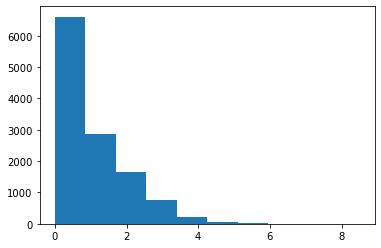

In [72]:
##total
plt.hist([i for i in df["mmol/g_working_capacity"]])

In [66]:
belowMOF=[i for i,row in phDF.iterrows() if row["belowPersistent"]>0]
belowMOF

[]

In [63]:
df.loc[aboveMOF[0]]

mmol/g_working_capacity    0.417868
selectivity                5.376075
Name: DB0-m23_o29_o29_f0_pcu, dtype: float64

In [75]:
# pvalue of drawing n points below 1.25

pAbove=sum([1 for i in df['mmol/g_working_capacity'] if i>1.25])/len(df['mmol/g_working_capacity'])

In [76]:
pAbove

0.3287435456110155

In [11]:
#grab below zero and above zero for now,

# the main hypothesis is that we'll see relevant points as some function of the persistence and it's birth distance away from zero

cols=phDF.columns
belowZero=phDF.iloc[:,:indexMap(1,0,mi,ma,thresh=1)]
aboveZero=phDF.iloc[:,indexMap(1,0,mi,ma,thresh=1):]

In [12]:
assert(len(belowZero.columns)+len(aboveZero.columns)==len(cols)) # let's work with a symmetric system for now ? build a persistence threshold
    #then a range of boxes OR a function of (dist(b,0),b-d)

In [17]:
#should we inverse the hash? Map these points to a set of filenames for later convenience

phMOFmap={k:set() for k in phDF.columns}
for i in phDF.index:
    for k in phDF.columns:
        if phDF.loc[i][k]>0:
            phMOFmap[k].add(i)

In [23]:
f=open("Z:/data/diverse_metals/phMOFmap-25_50.pkl","wb")
pickle.dump(phMOFmap,f)
f.close()

In [48]:
f=open("Z:/data/diverse_metals/phMOFmap-25_50.pkl","rb")
phMOFmap=pickle.load(f)
f.close()

In [ ]:
# color by mean of workingCap - 2SD of all bins, then plot

In [25]:
phMOFmap["50_50"]

{'DB0-m15_o19_nab',
 'DB0-m1_o24_o58_rna',
 'DB0-m1_o25_crs',
 'DB0-m1_o25_o29_f0_pcu',
 'DB0-m1_o25_snk',
 'DB0-m1_o26_stb',
 'DB0-m1_o32_o22_muo',
 'DB0-m1_o59_o3_rna',
 'DB0-m23_o29_o29_f0_pcu',
 'DB0-m2_o14_mou',
 'DB0-m2_o17_o19_f0_nbo.sym.54',
 'DB0-m2_o17_o22_f0_nbo.sym.116',
 'DB0-m2_o19_nog',
 'DB0-m2_o19_ucn',
 'DB0-m2_o20_o24_f0_nbo.sym.23',
 'DB0-m2_o21_pds',
 'DB0-m2_o21_ssd',
 'DB0-m2_o22_o25_f0_nbo.sym.18',
 'DB0-m2_o24_o27_f0_nbo.sym.29',
 'DB0-m2_o27_o27_f0_pcu.sym.31',
 'DB0-m2_o28_o28_f0_pcu.sym.61',
 'DB0-m2_o28_o28_f0_pcu.sym.63',
 'DB0-m2_o2_mgg',
 'DB0-m2_o33_o22_jea',
 'DB0-m2_o35_isx',
 'DB0-m2_o4_o25_f0_nbo.sym.15',
 'DB0-m2_o58_o19_zul',
 'DB0-m2_o58_o23_dme',
 'DB0-m2_o58_o24_dme',
 'DB0-m2_o6_o7_f0_nbo.sym.116',
 'DB0-m2_o7_o59_ins_0.359375_CN',
 'DB0-m3_o19_ptr',
 'DB0-m3_o19_umm',
 'DB0-m3_o1_xai',
 'DB0-m3_o20_o58_tfg',
 'DB0-m3_o21_brl',
 'DB0-m3_o22_o58_dme',
 'DB0-m3_o23_frl',
 'DB0-m3_o23_uob',
 'DB0-m3_o25_o29_f0_nbo.sym.2',
 'DB0-m3_o25_pcl',
 'DB0

In [31]:
phMOFmap["2_30"]

{'DB15-pcu_N123_E155_opt',
 'DB15-pcu_N139_E96_opt',
 'DB15-sxc_N123_E24_opt',
 'DB5-hypotheticalMOF_5039215_1_0_1_15_25_12',
 'DB5-hypotheticalMOF_5052944_1_0_1_27_18_4',
 'DB5-hypotheticalMOF_5056579_0_0_1_29_17_8',
 'DB5-hypotheticalMOF_5058348_0_0_1_29_23_8',
 'DB5-hypotheticalMOF_5065447_1_0_2_16_16_8',
 'DB5-hypotheticalMOF_5066311_0_0_2_8_17_4',
 'DB5-hypotheticalMOF_5071796_0_0_2_19_25_14',
 'DB5-hypotheticalMOF_5071918_1_0_2_19_24_5',
 'DB5-hypotheticalMOF_5074530_0_0_2_23_11_14',
 'DB7-ddmof_17084',
 'DB7-ddmof_22316',
 'DB7-ddmof_3089',
 'DB7-ddmof_3896',
 'DB7-ddmof_4315',
 'DB7-ddmof_5457',
 'DB7-ddmof_5705',
 'DB7-ddmof_6135'}

In [32]:
subCaps=[df.loc[k]["mmol/g_working_capacity"] for k in phMOFmap["2_30"]]


In [33]:
[np.mean(subCaps),np.std(subCaps)]

[0.5058317999999999, 0.41734246231297867]

In [34]:
np.max(subCaps)

1.649256

In [42]:
phMOFmap["-5_25"]

{'DB0-m18_o19_o147_f0_pcu',
 'DB0-m1_o16_o31_muo',
 'DB0-m1_o22_o28_f0_pcu',
 'DB0-m1_o32_o22_muo',
 'DB0-m1_o59_o9_ith-d',
 'DB12-CAVPUM_manual',
 'DB12-EPONEE_clean',
 'DB12-ICAROV_clean',
 'DB12-MUWQEB_freeONLY',
 'DB13-dia-Syn036822',
 'DB13-pcu-Syn037810',
 'DB15-cds_N29_E24_opt',
 'DB7-ddmof_16614',
 'DB7-ddmof_20996',
 'DB7-ddmof_21595',
 'DB7-ddmof_22188',
 'DB7-ddmof_22242',
 'DB7-ddmof_22528',
 'DB7-ddmof_23049',
 'DB7-ddmof_23114',
 'DB7-ddmof_23504',
 'DB7-ddmof_3705',
 'DB7-ddmof_3930',
 'DB7-ddmof_4183',
 'DB7-ddmof_5907',
 'DB7-ddmof_6411'}

In [43]:
subCaps=[df.loc[k]["mmol/g_working_capacity"] for k in phMOFmap["-4_30"]]
[np.mean(subCaps),np.std(subCaps),np.max(subCaps)]

[0.42630720000000005, 0.49932733135131574, 2.583516]

In [45]:
subCaps=[df.loc[k]["mmol/g_working_capacity"] for k in phMOFmap["-10_26"]]
[np.mean(subCaps),np.std(subCaps),np.max(subCaps)]

[0.209858, 0.0, 0.209858]

In [46]:
phMOFmap["-10_26"] # our hope is that this MOF has an incredible amt of persistent points above the thresh to "balance out" for this good point.

{'DB7-ddmof_18943'}

In [47]:
from functools import reduce



set()

In [37]:
np.max(subCaps)

2.583516

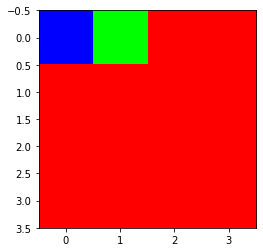

In [52]:
red=(255,0,0)
blue=(0,0,255)
green=(0,255,0)
h,w,channel=4,4,3
im=np.full((h,w,channel),[255,0,0],dtype=np.uint8)
im[0,0]=blue
im[0,1]=green

plt.imshow(im)

In [55]:
import os
import sys
import numpy as np
import pandas as pd
import multiprocessing
from multiprocessing.dummy import Pool
from functools import reduce
import pickle

df=pd.read_csv(r"Z:\data\diverse_metals\post-combustion-vsa-2-clean.csv",index_col=0)
phDF=pd.read_csv("Z:/data/diverse_metals/phDF_tThresh0_B1.csv",index_col=0)

f=open("Z:/data/diverse_metals/phMOFmap-25_50.pkl","rb")
phMOFmap=pickle.load(f)
f.close()


channels=3
red=(255,0,0)
green=(0,255,0)
blue=(0,0,255)
colorCodes={'max':red,'min':blue}


b0thresh=[-25,50]
mi,ma=b0thresh
life=ma-mi
#meanBox=np.zeros((life+1,life+1,channels),dtype='uint8')
meanBox=np.zeros((life+1,life+1),dtype=np.float64)
#varBox=np.zeros((life+1,life+1,channels),dtype='uint8')
varBox=np.zeros((life+1,life+1),dtype=np.float64)

optVar="mmol/g_working_capacity"
boundOpt=[np.min(df[optVar]),np.max(df[optVar])]

def arrayImageIndexMap(b,d,mi,ma):
    return [ma-d,b-mi]




def grabStatsBox(k): ## ie k = "50_50" the key to the associating region in bounding box-
    mi=-25;ma=50

    b,d=[int(i) for i in k.split("_")]
    subset = np.array([df.loc[k][optVar] for k in phMOFmap[k]],dtype=np.float64)
    if len(subset)>0:
        #inds=arrayImageIndexMap(b,d,mi,ma)
        meanBox[ma-d,b-mi]=np.mean(subset)
        if len(subset)>1:
            varBox[ma-d,b-mi]=np.var(subset)

for k in set(phMOFmap.keys())-set(["belowPersistent","abovePersistent","belowWeak","aboveWeak"]):
    grabStatsBox(k)

In [57]:
bounds={"mean":np.max(meanBox),"var":np.max(varBox)}
bounds

{'mean': 4.68975, 'var': 4.7350173440902505}

In [58]:
np.median([i for i in meanBox.flatten() if i!=0]) #too diluted with bad candidates, let's naturally use 2 as the thresh

0.40546290000000007

In [59]:
np.median([i for i in varBox.flatten() if i!=0]) #too diluted with bad candidates, let's naturally use 1 as the thresh


0.15007766140316808

In [99]:
np.median(df['mmol/g_working_capacity'])

0.75396

In [101]:
channels=3
meanBoxColor=np.zeros((life+1,life+1,channels),dtype='uint8')
varBoxColor=np.zeros((life+1,life+1,channels),dtype='uint8')
medBound=1.5#np.median(df['mmol/g_working_capacity'])#np.median([i for i in meanBox.flatten() if i!=0])
varBound=.45

red=np.array((255,0,0),dtype="uint8")
green=np.array((0,255,0),dtype="uint8")
blue=np.array((0,0,255),dtype="uint8")
colorCodes={'max':red,'min':blue}
colorCodesVar={'max':(red+green)*.75,'min':(blue+green)*.5}
for b in np.arange(mi,ma+1):
    for d in np.arange(b,ma+1):
        meanExam=meanBox[ma-d,b-mi]
        if meanExam>0:#np.isclose(meanExam,0):

            if meanExam<medBound: # color blue (bluer candidates closer to 0
                meanBoxColor[ma-d,b-mi,:]=np.round(colorCodes["min"]*(medBound-meanExam)/medBound)
            else:
                meanBoxColor[ma-d,b-mi,:]=np.round(colorCodes["max"]*(meanExam-medBound)/(bounds["mean"]-medBound))

            varExam=varBox[ma-d,b-mi]
            if varExam>0:#not np.isclose(varExam,0):
                if varExam<varBound:
                    varBoxColor[ma-d,b-mi,:]=np.round(colorCodesVar["min"]*(varBound-varExam)/varBound)
                else:
                    varBoxColor[ma-d,b-mi,:]=np.round(green*(varExam-varBound)/(bounds["var"]-varBound))




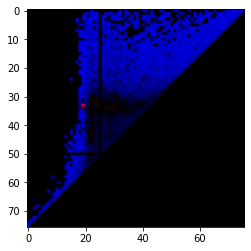

In [102]:
plt.imshow(meanBoxColor) # yay red :)

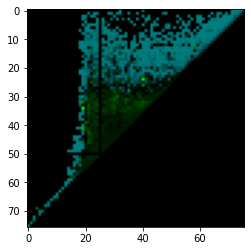

In [100]:
plt.imshow(varBoxColor)

### This code can/should be reused to plot the distribution correlations in B0,B2, and other topological transforms

In [68]:
mi,ma

(-25, 50)

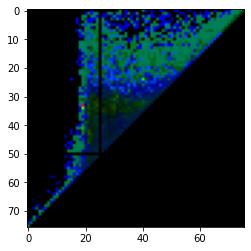

In [103]:
plt.imshow(varBoxColor+meanBoxColor)